In [ ]:
from pathlib import Path
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cpu


In [ ]:
img_size = 784
img_shape = (28, 28)


def one_hot(n, i):
    q = np.zeros(n)
    q[i] = 1.0
    return q


class MNISTDataset(Dataset):
    def __init__(self, fp):
        xy = np.loadtxt(fp, delimiter=',', dtype=np.float32)

        self.n_samples = xy.shape[0]

        self.x = torch.from_numpy(xy[:, 1:])
        self.x = self.x / 255.0

        labels = []
        for i in xy[:, 0]:
            labels.append(one_hot(10, int(i)))
        self.y = torch.from_numpy(np.array(labels))


    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.n_samples

In [ ]:
train_dataset = MNISTDataset(Path('/content/sample_data/mnist_train_small.csv'))
test_dataset = MNISTDataset(Path('/content/sample_data/mnist_test.csv'))

In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, n_in, n_hidden):
        super().__init__()

        self.n_in = n_in
        self.n_hidden = n_hidden

        self.h = nn.Linear(self.n_in, self.n_hidden)
        self.f = nn.Sigmoid()

    def forward(self, x):
        return self.f(self.h(x))

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    for (x, y) in dataloader:
        x = x.to(device)
        h = model(x)

        loss = loss_fn(h)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

In [ ]:
s = nn.Softmax(dim=1)

def loss_fn(t: torch.Tensor) -> torch.Tensor:
    # return torch.sum(t*torch.log(t), dim=1).sum()
    return torch.sum(t*torch.log(t)+(1-t)*torch.log(1-t), dim=1).sum()
    # return torch.sum(s(t)*torch.log(t),dim=1).sum()

In [ ]:
n_in = 784
n_hidden = 16

learning_rate = 1e-3

model = Perceptron(n_in, n_hidden).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
n_eras = 8
n_epoch = 2

start_t = time.time()

for i in range(n_eras):
    w_old = model.h.weight.detach().clone()
    b_old = model.h.bias.detach().clone()

    for j in range(n_epoch):
        train(train_dataloader, model, loss_fn, optimizer)

    with torch.no_grad():
        model.h.weight -= w_old
        model.h.bias -= b_old

print(f"done ({round(time.time()-start_t, 2)} sec.)")


done (4.85 sec.)


In [ ]:
from matplotlib import pyplot as plt

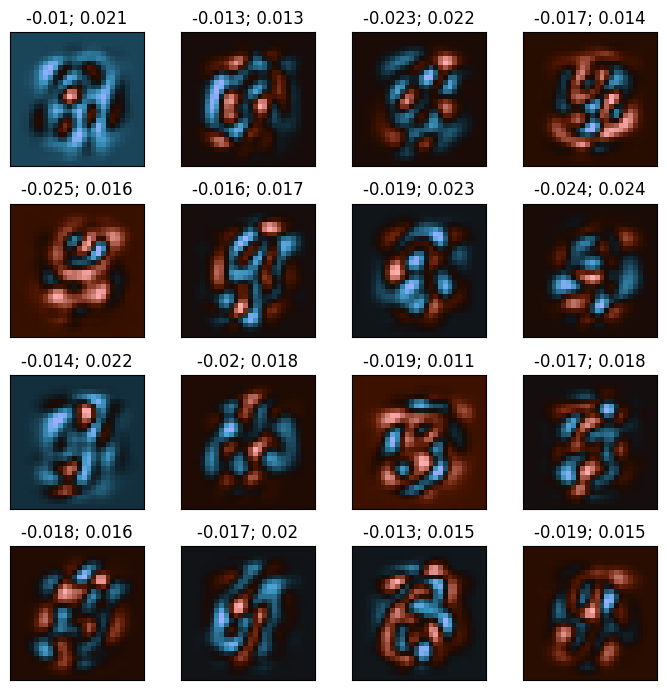

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4)

fig.set_dpi(100)
fig.set_figwidth(7)
fig.set_figheight(7)

w = model.h.weight.detach().numpy()

for i, ax in enumerate(axes.ravel()):
    v = -1 + 2 * (w[i]-np.min(w[i]))/(np.max(w[i]-np.min(w[i])))
    img = ax.imshow(v.reshape(img_shape),  cmap='berlin')
    ax.set_title(f"{round(float(np.min(w[i])), 3)}; {round(float(np.max(w[i])), 3)}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
x = torch.randint(1, 10, (2,3))

# l1 = (2*x[0]*torch.log(x[0]) - torch.sum(x[0]*torch.log(x), dim=0)).sum()

print(x)

tensor([[1, 3, 2],
        [9, 2, 4]])


In [ ]:
t = torch.ones(2, 2, 3)
t *= x
t = x.unsqueeze(1)*torch.log(t)

print(t)
print(torch.sum(t,dim=2))

q = torch.sum(2*x*torch.log(x), dim=1).unsqueeze(1)
print(q)

p = torch.sum(torch.sum(t,dim=2), dim=1)
print(p)

print(torch.sum(q*p))

tensor([[[ 0.0000,  3.2958,  1.3863],
         [ 2.1972,  2.0794,  2.7726]],

        [[ 0.0000,  2.1972,  2.7726],
         [19.7750,  1.3863,  5.5452]]])
tensor([[ 4.6821,  7.0493],
        [ 4.9698, 26.7065]])
tensor([[ 9.3643],
        [53.4130]])
tensor([11.7314, 31.6763])
tensor(2725.0156)
